# Notes on Chapter 8 of *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow* by Aurélien Géron

In [1]:
import tempfile
import time

import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from sklearn.datasets import fetch_openml, load_digits, make_swiss_roll
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding, TSNE
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

Generate a simple dataset from a bivariate Gaussian:

In [2]:
np.random.seed(52)
theta = np.random.uniform(0, np.pi)
U = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])
eigenvals = np.random.uniform(0,4,size=2)
cov = np.einsum('ik,k,jk->ij', U, eigenvals**2, U)
N = 1000
X = np.random.multivariate_normal([0,0], cov, size=N)

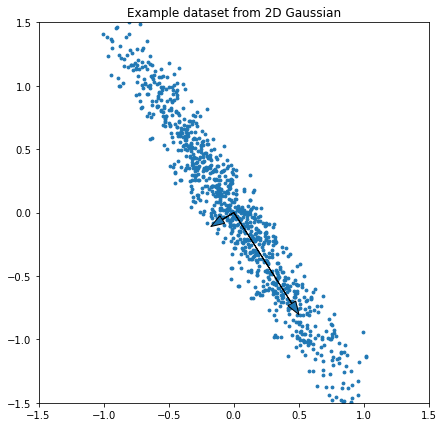

In [3]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], s=8)
plt.arrow(0, 0, eigenvals[0]*U[0,0], eigenvals[0]*U[1,0], head_width=0.07)
plt.arrow(0, 0, eigenvals[1]*U[0,1], eigenvals[1]*U[1,1], head_width=0.07)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title("Example dataset from 2D Gaussian");

Perform PCA using SVD:

In [4]:
u,s,vh = np.linalg.svd(X.transpose())

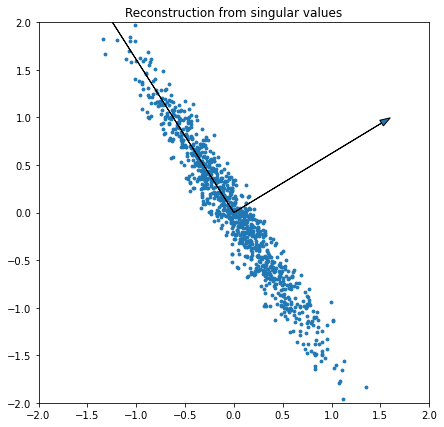

In [5]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], s=8)
#plt.plot([0, vh[0,0]], [0, vh[0,1]])
esteigen = np
plt.arrow(0, 0, u[0,0]*np.sqrt(s[0]), u[0,1]*np.sqrt(s[0]), head_width=0.07)
plt.arrow(0, 0, u[1,0]*np.sqrt(s[1]), u[1,1]*np.sqrt(s[1]), head_width=0.07)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Reconstruction from singular values");

Plot the principle components

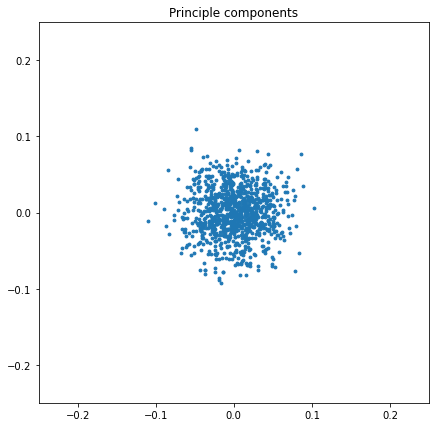

In [6]:
pc = np.einsum('ij,jk,k->ik', X, u, s**-1)
plt.figure(figsize=(7,7))
plt.scatter(pc[:,0], pc[:,1], s=8)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.title("Principle components");

Just unrotate to align axes with priniple components (trival to project from here...)

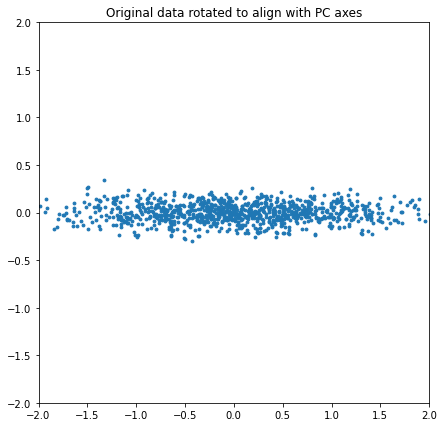

In [7]:
pc = np.einsum('ij,jk->ik', X, u)
plt.figure(figsize=(7,7))
plt.scatter(pc[:,0], pc[:,1], s=8)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Original data rotated to align with PC axes");

Do the same thing with sklearn

In [8]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

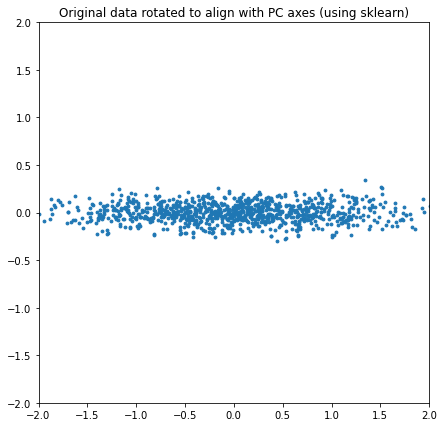

In [9]:
plt.figure(figsize=(7,7))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title("Original data rotated to align with PC axes (using sklearn)");

In [10]:
pca.explained_variance_

array([0.73386552, 0.0100676 ])

In [11]:
eigenvals**2

array([0.01091438, 0.7107882 ])

Load the MNIST dataset

In [12]:
mnist = load_digits()

In [13]:
mnist.images.shape

(1797, 8, 8)

In [14]:
mnist.data.shape

(1797, 64)

In [15]:
def plot_digits(data, nrows = 8, ncols = 8):
    fig, axs = plt.subplots(nrows, ncols)
    for i in range(nrows):
        for j in range(ncols):
            image = data[i + j*nrows].reshape((8,-1))
            axs[i,j].imshow(image, cmap='binary') 
    return fig

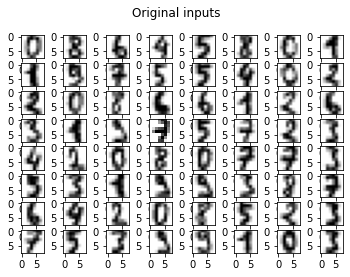

In [16]:
plot_digits(mnist.data).suptitle("Original inputs");

PCA can be used to compress the MNIST data by a factor of 6 or so:

In [17]:
pca = PCA(n_components=0.75)
mnist_pca = pca.fit_transform(mnist.data)

In [18]:
mnist_pca.shape

(1797, 11)

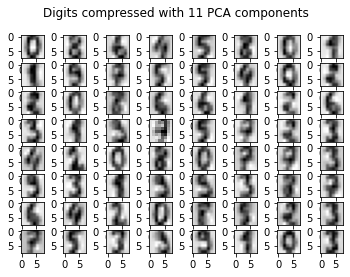

In [19]:
plot_digits(pca.inverse_transform(mnist_pca)).suptitle("Digits compressed with 11 PCA components");

The principle components for this example do not map cleanly onto the digits, however:

Text(0.5, 0.98, 'PCA components')

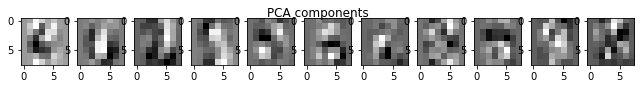

In [20]:
nrows = 1
ncols = pca.n_components_
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(ncols, nrows))
for i in range(nrows):
    for j in range(ncols):
        image = pca.components_[i + j*nrows].reshape((8,-1))
        axs[i,j].imshow(image, cmap='binary') ;
fig.suptitle("PCA components")

PCA can be run online/incrementally using partial_fit:

In [21]:
inc_pca = IncrementalPCA(n_components=11)
batch_size = 100
for i in range(0, mnist.data.shape[0], batch_size):
        top = i + batch_size
        if top > mnist.data.shape[0]:
            top = -1
        inc_pca.partial_fit(mnist.data[i:top,:])
mnist_pca = inc_pca.transform(mnist.data[0:64])

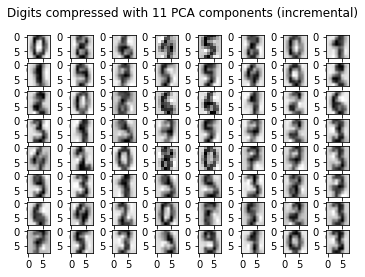

In [22]:
plot_digits(inc_pca.inverse_transform(mnist_pca)).suptitle("Digits compressed with 11 PCA components (incremental)");

One can also use numpy's memmap class to handle the incremental loading, in which case the fit function can (in theory) be used with a manually specified batch size:

In [23]:
inc_pca = IncrementalPCA(n_components=11, batch_size=100)
with tempfile.TemporaryFile() as f:
    # save the data to a tempfile (pretending it is a much larger dataset)
    mnist_mm = np.memmap(f, dtype='float32', shape=mnist.data.shape)
    mnist_mm[:] = mnist.data[:]

    # call fit with a batch size
    inc_pca.fit(mnist_mm)

mnist_pca = inc_pca.transform(mnist.data[0:64])

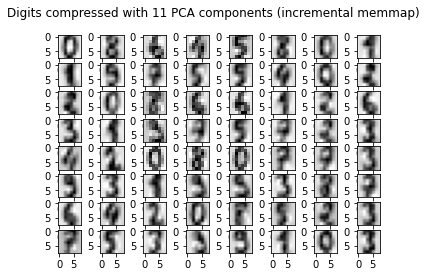

In [24]:
plot_digits(inc_pca.inverse_transform(mnist_pca)).suptitle("Digits compressed with 11 PCA components (incremental memmap)");

A classic dataset for dimensional reduction algorithms is the swiss roll:

In [25]:
X_swiss, y_swiss = make_swiss_roll(n_samples=2000, noise=0.5, random_state=42)

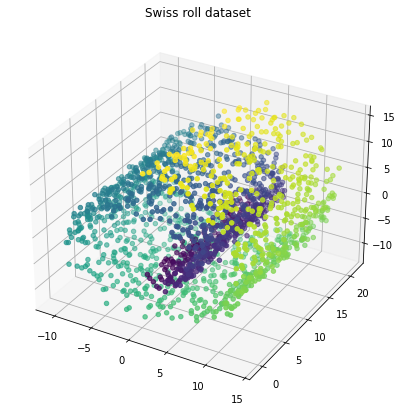

In [26]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.set_title("Swiss roll dataset")
ax.scatter(X_swiss[:,0], X_swiss[:,1], X_swiss[:,2], c=y_swiss);

Text(0.5, 1.0, '2d projection (axes 0 and 2) of Swiss Roll Dataset')

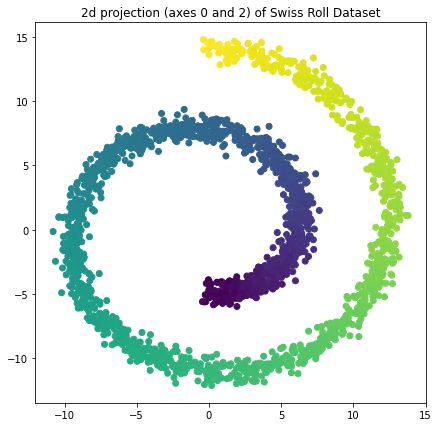

In [27]:
fig = plt.figure(figsize=(7,7))
plt.scatter(X_swiss[:,0], X_swiss[:,2], c=y_swiss);
plt.title("2d projection (axes 0 and 2) of Swiss Roll Dataset")

We can do PCA using the kernel trick with this dataset with multiple kernels:

Reconstruction MSE: 29.328147777530898


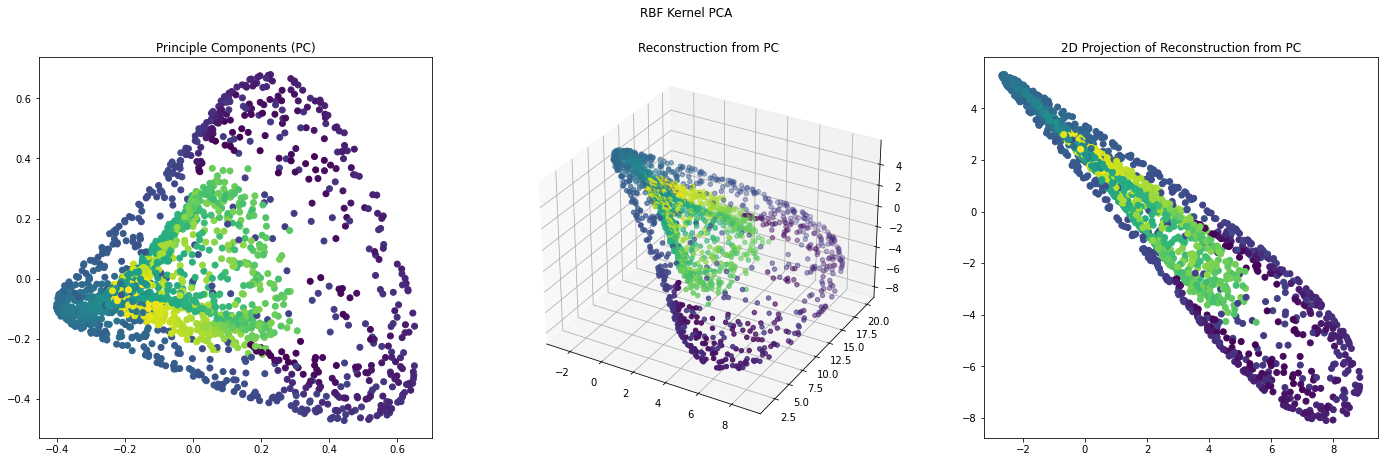

In [28]:
swiss_rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.03, random_state=42, fit_inverse_transform=True)
pc_swiss_rbf = swiss_rbf_pca.fit_transform(X_swiss)
swiss_pca_inverse = swiss_rbf_pca.inverse_transform(pc_swiss_rbf)
fig = plt.figure(figsize=(24,7))
fig.suptitle("RBF Kernel PCA")
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Principle Components (PC)")
ax1.scatter(pc_swiss_rbf[:,0], pc_swiss_rbf[:,1], c=y_swiss)
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,1], swiss_pca_inverse[:,2], c=y_swiss)
ax2.set_title("Reconstruction from PC")
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,2], c=y_swiss)
ax3.set_title("2D Projection of Reconstruction from PC")
print(f"Reconstruction MSE: {mean_squared_error(X_swiss, swiss_pca_inverse)}")

Reconstruction MSE: 42.27888971703708


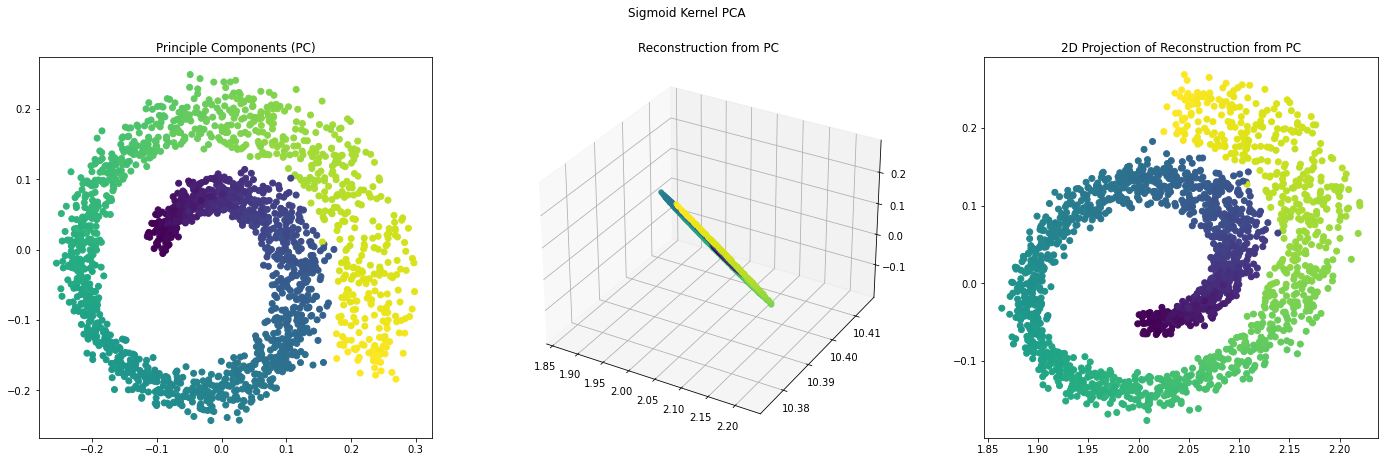

In [29]:
swiss_rbf_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, random_state=42, fit_inverse_transform=True)
pc_swiss_rbf = swiss_rbf_pca.fit_transform(X_swiss)
swiss_pca_inverse = swiss_rbf_pca.inverse_transform(pc_swiss_rbf)
fig = plt.figure(figsize=(24,7))
fig.suptitle("Sigmoid Kernel PCA")
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Principle Components (PC)")
ax1.scatter(pc_swiss_rbf[:,0], pc_swiss_rbf[:,1], c=y_swiss)
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,1], swiss_pca_inverse[:,2], c=y_swiss)
ax2.set_title("Reconstruction from PC")
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,2], c=y_swiss)
ax3.set_title("2D Projection of Reconstruction from PC")
print(f"Reconstruction MSE: {mean_squared_error(X_swiss, swiss_pca_inverse)}")

Reconstruction MSE: 49.73854354736861


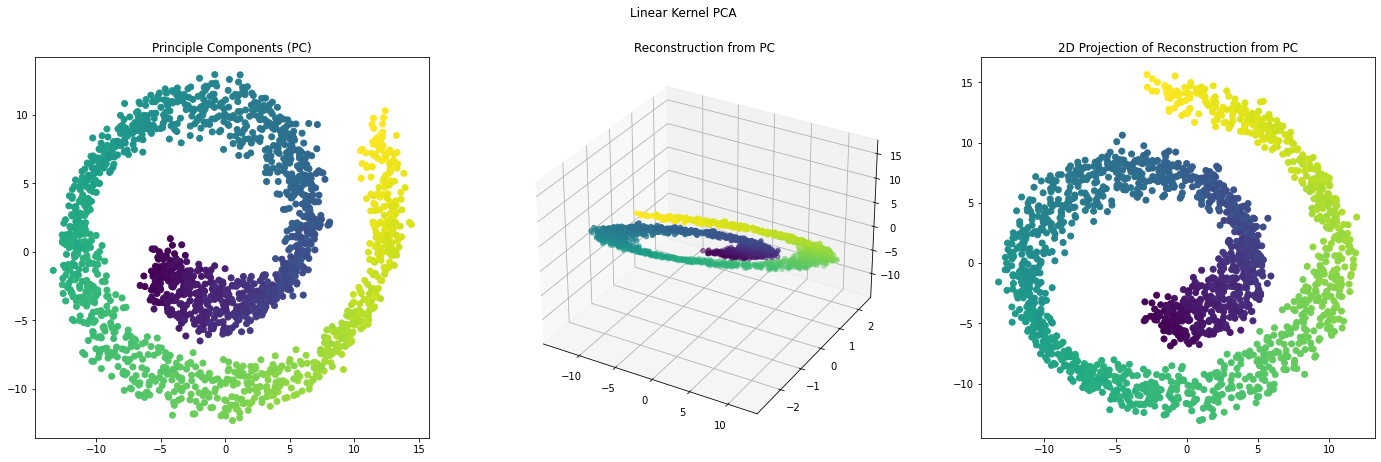

In [30]:
swiss_rbf_pca = KernelPCA(n_components=2, kernel="linear", random_state=42, fit_inverse_transform=True)
pc_swiss_rbf = swiss_rbf_pca.fit_transform(X_swiss)
swiss_pca_inverse = swiss_rbf_pca.inverse_transform(pc_swiss_rbf)
fig = plt.figure(figsize=(24,7))
fig.suptitle("Linear Kernel PCA")
ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Principle Components (PC)")
ax1.scatter(pc_swiss_rbf[:,0], pc_swiss_rbf[:,1], c=y_swiss)
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax2.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,1], swiss_pca_inverse[:,2], c=y_swiss)
ax2.set_title("Reconstruction from PC")
ax3 = fig.add_subplot(1,3,3)
ax3.scatter(swiss_pca_inverse[:,0], swiss_pca_inverse[:,2], c=y_swiss)
ax3.set_title("2D Projection of Reconstruction from PC")
print(f"Reconstruction MSE: {mean_squared_error(X_swiss, swiss_pca_inverse)}")

Build an MNIST predictor using PCA for dimensional reduction followed by logistic regression for classifiction

In [31]:
m = Pipeline([
    ("pca", PCA(random_state=42)),
    ("lr", LogisticRegression(random_state=42, max_iter=1000))
])
grid_search = GridSearchCV(m, [{
    "pca__n_components": range(30,40)
}], cv=8, n_jobs=8, scoring="accuracy")
grid_search.fit(mnist.data, mnist.target);

In [32]:
grid_search.best_params_

{'pca__n_components': 35}

In [33]:
grid_search.best_score_

0.9293154761904762

Another option for dimensional reduction is a locally linear embedding:

Text(0.5, 1.0, 'LLE of Swiss roll')

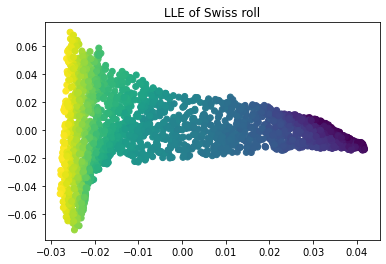

In [34]:
swiss_lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_swiss_lle = swiss_lle.fit_transform(X_swiss)
plt.scatter(X_swiss_lle[:,0], X_swiss_lle[:,1], c=y_swiss)
plt.title("LLE of Swiss roll")

## Exercises

### 8.1

Benefits: simplifies visualization and processing, can act as a form of regularization.
Risks: loss of information that may be useful for prediction or understanding the data generation process.

### 8.2

Higher dimensional datasets require exponentially larger samples to sample with a given resolution.

### 8.3

Typically the methods of dimensional reduction will discard data (e.g. via projection) which cannot be recovered. In priciple, a bijective map from the space $\mathbb{Q}^n$ with $n \in \mathbb{Z}^+$ to $\mathbb{Q}^m$ with $m \in \mathbb{Z}^+$ can be constructed for arbitrary values of m and n can be constructed (as can a bijection between $\mathbb{R}^n$ and $\mathbb{R}^m$). In practice, finite precision is generally used and a partial loss of information is accepted.

To see how the bijective map from space $\mathbb{Q}^n$ to $\mathbb{Q}^m$ could be constructed, we first note that (as an extension of the fundemental theorem of arithmetic) any rational number $u$ can be uniquely described by a set of coefficents $u_i \in \mathbb{Z}$ for all $i \in \mathbb{N}$ where
$$u = (-1)^{u_0} \prod_{i \in \mathbb{Z}^+} p_i^{u_i}$$
where $p_i$ is the $i$-th prime number (e.g. $p_1 = 2, p_2 = 3, p_3 = 5, \ldots$). We then define the bijective map $g: \mathbb{Q}^2 \to \mathbb{Q}$ as
$$g(u,v) = (-1)^{u_0} \prod_{i \in \mathbb{Z}^+} p_{2i}^{u_i} \prod_{j \in \mathbb{Z}^+} p_{2j - 1}^{v_{j-1}}.$$
The remainder of the definition follows trivially by induction.

A similar construction can be used for $\mathbb{R}$ using the infinite decimal expansion of each number.

### 8.4

Because (standard) PCA is only a linear transform, a non-linear manifold will span across linear subspaces and thus only the subspaces that it does not span across (or spans only weakly across if loss of information is acceptable) will be able to be reliably elimited with PCA.

### 8.5

Assuming each dimension is indepentent and identically distributed, 950 dimensions (obviously the number of dimensions could be as low as 1, e.g. if the dataset lies on a 1 dimensional linear manifold. 

### 8.6

Vanilla PCA can be a good choice when the number of datapoints are and dimensions are relatively small and comperable in size. Randomized PCA can be much faster when the number of dimensions is significantly smaller than the number of datapoints. Incremental PCA can be used when online predictions must be made (e.g. using the model while improving it with new data) and with large datasets. Kernel PCA may be useful for preserving features of non-Gaussian data, e.g. maintaining clusters or unwrapping non-linear manifolds, but does not scale as well to large datasets.

### 8.7

One common technique for evaluating the performance of a dimensional reduction technique is to look for the minimum number of dimensions needed to capture a given fraction of the variance in the dataset. In practice, however, some parts of variance in the dataset are more useful than others, and it is best to test the impact of a dimensional reduction technique on an appropriate metric for the problem (e.g. accuracy of a prediction model).

### 8.8

In some cases it can make sense to chain together dimensional reduction techniques (e.g. if one works well for unrolling a manifold and another can further reduce the dimensionality while preserving clusters on that manifold). This can result in a more complex model that is more difficult to tune, however, so in general this should be done in the context of careful experimentation and benchmarking after building a simpler model for comparison.

### 8.9

In [35]:
mnist_full = fetch_openml('mnist_784', version=1)

In [36]:
mnist_full.data.shape

(70000, 784)

In [37]:
mnist_full.target.shape

(70000,)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(mnist_full.data, mnist_full.target,
    train_size=60000, random_state=42)

Here is an example without dimensional reduction:

In [39]:
start_time = time.monotonic()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print(f"Execution time: about {round(time.monotonic() - start_time, -1):.0f} seconds")

Execution time: about 20 seconds


In [40]:
y_hat_test = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_hat_test, y_test):0.3f}")

Accuracy: 0.967


Here is an example with dimensional reduction:

In [41]:
start_time = time.monotonic()
pca_rf = Pipeline([
    ("pca", PCA(random_state=42, n_components=0.95)),
    ("rf", RandomForestClassifier(random_state=42))
])
pca_rf.fit(X_train, y_train)
print(f"Execution time: about {round(time.monotonic() - start_time, -1):.0f} seconds")

Execution time: about 60 seconds


In [42]:
y_hat_test = pca_rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_hat_test, y_test):0.3f}")

Accuracy: 0.947


As coded above, doing the dimensional reduction seems to take longer to train and produces a less accurate model.

### 8.10

First, we fit the t-SNE map (after reducing the number of dimensions with PCA, as recommended by the documentation):

In [43]:
start_time = time.monotonic()
pca_tsne = Pipeline([
    ("pca", PCA(random_state=42, n_components=50)),
    ("tsne", TSNE(random_state=42, init="random", learning_rate="auto"))
])
x_tsne = pca_tsne.fit_transform(X_train, y_train)
print(f"Execution time: about {round(time.monotonic() - start_time, -1):.0f} seconds")

Execution time: about 90 seconds


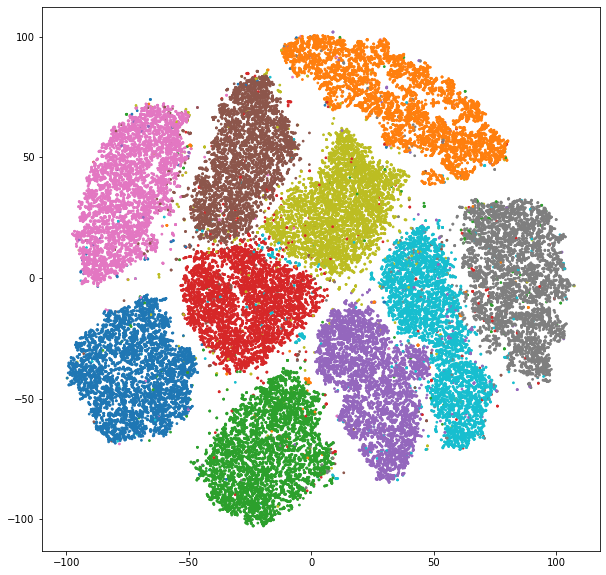

In [44]:
plt.figure(figsize=(10,10))
plt.scatter(x_tsne[:,0], x_tsne[:,1],c=y_train[:].astype(int).tolist(), s=3, cmap='tab10');